In [16]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

### Sequence Lengths

In [54]:
def get_data(dataset):
    """
    dataset has to be in {COVIDNEWS, SciERC, WNUT16}.
    """
    data_train_weak = pd.read_csv(f'../data/{dataset}/__init/weak/data_train.csv', index_col=0)
    data_train_strong = pd.read_csv(f'../data/{dataset}/__init/strong/data_train.csv', index_col=0)
    data_test_strong = pd.read_csv(f'../data/{dataset}/__init/strong/data_test.csv', index_col=0)
    
    return data_train_weak, data_train_strong, data_test_strong

In [86]:
def plot_sequence_dist(dataset):
    
    tr_w, tr_s, ts_s = get_data(dataset)
    
    sl_tr_w = tr_w['sequence_tok'].apply(lambda x: len(x))
    sl_tr_s = tr_s['sequence_tok'].apply(lambda x: len(x))
    sl_ts_s = ts_s['sequence_tok'].apply(lambda x: len(x))
    
    sl_tr_w_mean = np.mean(sl_tr_w)
    sl_tr_s_mean = np.mean(sl_tr_s)
    sl_ts_s_mean = np.mean(sl_ts_s)

    plt.figure(figsize=(10,6))
    sns.kdeplot(sl_tr_w, shade=True, label='Weak Train')
    sns.kdeplot(sl_tr_s, shade=True, label='Strong Train')
    sns.kdeplot(sl_ts_s, shade=True, label='Strong Test')
    plt.axvline(sl_tr_w_mean, color='blue', label = f"Weak Train Mean ({sl_tr_w_mean.round(1)})")
    plt.axvline(sl_tr_s_mean, color='orange', label = f"Strong Train Mean ({sl_tr_s_mean.round(1)})")
    plt.axvline(sl_ts_s_mean, color='green', label = f"Strong Test Mean ({sl_ts_s_mean.round(1)})")
    plt.xlabel('Sequence Length')
    plt.legend()

    plt.savefig(f'../data/{dataset}/descriptives/{dataset}_sequence_lengths.pdf', bbox_inches='tight')
    plt.show()

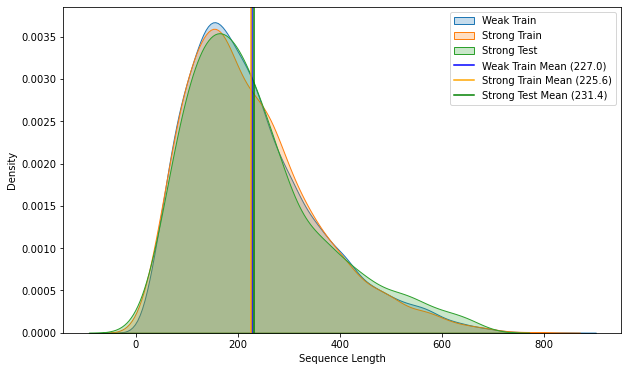

In [87]:
plot_sequence_dist('COVIDNEWS')

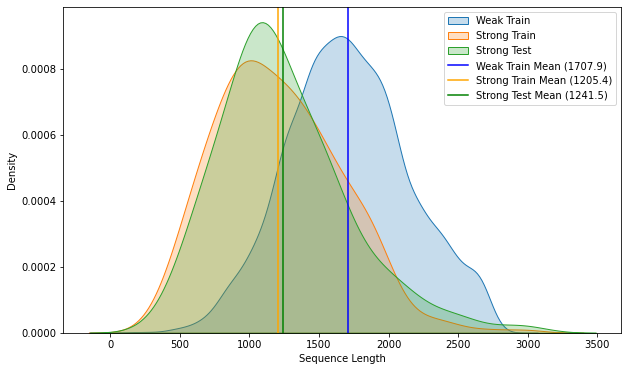

In [89]:
plot_sequence_dist('SciERC')

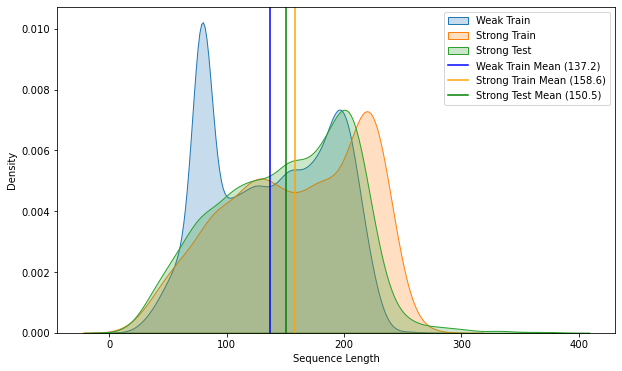

In [90]:
plot_sequence_dist('WNUT16')

### Label Distributions - Skweak output vs. strong labels

In [196]:
from collections import Counter
from functools import reduce

In [93]:
def get_skweak_strong_data(dataset):
    """
    dataset has to be in {COVIDNEWS, SciERC, WNUT16}.
    """
    data_train_skweak = pd.read_csv(f'../data/{dataset}/dist_skweak/data_train.csv', index_col=0)
    data_train_strong = pd.read_csv(f'../data/{dataset}/__init/strong/data_train.csv', index_col=0)
    data_test_strong = pd.read_csv(f'../data/{dataset}/__init/strong/data_test.csv', index_col=0)
    
    return data_train_skweak, data_train_strong, data_test_strong

In [244]:
data_train_skweak, data_train_strong, data_test_strong = get_skweak_strong_data('COVIDNEWS')

In [248]:
weak_labels = " ".join(data_train_skweak["labels"].apply(lambda x: x.strip("\n"))).split(" ")

strong_labels_train = " ".join(data_train_strong["labels"].apply(lambda x: x.strip("\n"))).split(" ")

strong_labels_test = " ".join(data_test_strong["labels"].apply(lambda x: x.strip("\n"))).split(" ")

In [256]:
# first: clean up label format
def remap_labels(label):
    label_mapping = {
        'ORG': 'organization',
        'GPE': 'location',
        'PERSON' : 'person',
        'TIME' : 'time', # needs to be changed to time
        'DISEASE' : 'disease',
        'VIRUS' : 'virus',
        'PRODUCT' : 'product',
        'ANIMAL' : 'animal',
        'SYMPTOM' : 'symptom',
        'BACTERIA' : 'bacterium'
    }
    
    return label_mapping.get(label, label)

weak_labels = [remap_labels(label) for label in weak_labels]

In [257]:
def remove_prefix(label):
    if label.startswith('B-'):
        return label[2:]
    elif label.startswith('I-'):
        return label[2:]
    else:
        return label

In [258]:
strong_labels_train = [remove_prefix(label) for label in strong_labels_train]
strong_labels_test = [remove_prefix(label) for label in strong_labels_test]

In [259]:
c_tr_s = Counter(strong_labels_train)
c_ts_s = Counter(strong_labels_test)
c_tr_w = Counter(weak_labels)

df_tr_s = pd.DataFrame(c_tr_s.most_common(), columns=['label', 'Strong Train'])
df_ts_s = pd.DataFrame(c_ts_s.items(), columns=['label', 'Strong Test'])
df_tr_w = pd.DataFrame(c_tr_w.items(), columns=['label', 'Weak Train'])
# get relative frequency
df_tr_s['Strong Train'] = df_tr_s['Strong Train'] / sum(c_tr_s.values())
df_ts_s['Strong Test'] = df_ts_s['Strong Test']/ sum(c_ts_s.values())
df_tr_w['Weak Train'] = df_tr_w['Weak Train']/ sum(c_tr_w.values())


dfs = [df_tr_s, df_ts_s, df_tr_w]

final_df = reduce(lambda left,right: pd.merge(left,right,on=['label'],
                                            how='outer'), dfs)

In [260]:
final_df.drop(0, inplace=True)

In [261]:
final_df.fillna(0, inplace=True)

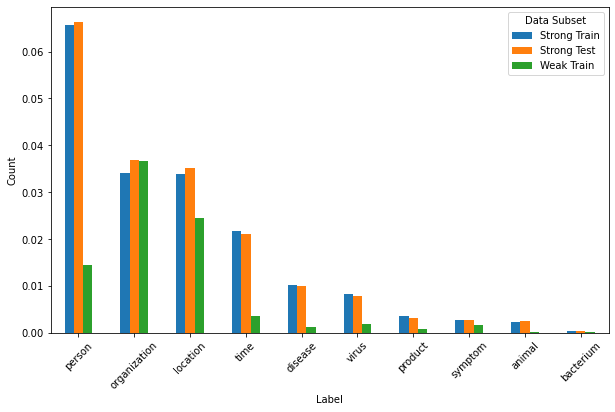

In [265]:
df = final_df.copy()
df.set_index('label', inplace=True)

# Plot the counts for each distribution
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Label')
plt.ylabel('Count')
#plt.title('Relative Label Frequency')
plt.legend(title='Data Subset')
plt.xticks(rotation=45)
plt.savefig(f'../data/COVIDNEWS/descriptives/COVIDNEWS_label_frequency.pdf', bbox_inches='tight')
plt.show()

In [271]:
final_df.round(3)

,label,Strong Train,Strong Test,Weak Train
1,person,0.066,0.066,0.014
2,organization,0.034,0.037,0.037
3,location,0.034,0.035,0.025
4,time,0.022,0.021,0.004
5,disease,0.010,0.010,0.001
6,virus,0.008,0.008,0.002
7,product,0.004,0.003,0.001
8,symptom,0.003,0.003,0.002
9,animal,0.002,0.003,0.000
10,bacterium,0.000,0.000,0.000
